In [1]:
import boule as bl
import ensaio
import numpy as np
import pandas as pd
import pygmt
import verde as vd
import xarray as xr
import harmonica as hm
import scipy as scipy
from numba import njit
import matplotlib.pyplot as plt

# Load Moho & LAB and NearestNDInterpolator Function

In [2]:
# Moho                     
moho_file_path = 'moho_depth.csv'
moho_df = pd.read_csv(moho_file_path)

camlab_file_path = "D:\\Amitava\\Projects\\Perple_X\\V2RhoT_gibbs\\LAB_geoid_data\\CAM2022_lithosphere.xyz"
camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])

fname = ensaio.fetch_earth_topography(version=1)
topo = xr.load_dataarray(fname)

# Topo
topo_file_path = r"D:\Amitava\Projects\Perple_X\topo\etopo2_downsampled.csv"
topo_df = pd.read_csv(topo_file_path, usecols=['x', 'y', 'z'])
topo_df.rename(columns={'x': 'Longitude', 'y': 'Latitude', 'z': 'Topo'}, inplace=True)      # Rename columns to match interpolation logic
topo_df = topo_df[['Latitude', 'Longitude', 'Topo']]  # Reorder columns

C:\Users\DELL\AppData\Local\Temp\ipykernel_11228\1790229125.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])


In [3]:
moho_func = scipy.interpolate.NearestNDInterpolator(list(zip(moho_df['Latitude'], moho_df['Longitude'])), moho_df['Moho'])
camlab_func = scipy.interpolate.NearestNDInterpolator(list(zip(camlab_df['Latitude'], camlab_df['Longitude'])), camlab_df['Depth'])
topo_func = scipy.interpolate.NearestNDInterpolator(list(zip(topo_df['Latitude'], topo_df['Longitude'])), topo_df['Topo'])

In [4]:
#region = [west, east, south, north]
#region = [-78, -53, -57, -20] # SA
#region = [112, 155, -45, -10]  # Australia
#region = [68, 98, 6, 38]  # India
region = [-179.9, 179.9, -89.9, 89.9] # World

In [5]:
import random

# Get a random integer between 1 and 10 (inclusive)
random_integer = random.random()
print(random_integer)

0.38829721400161643


# Gravity field for different density layers

In [6]:
'''
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius which we'll use to
# reference the tesseroid
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

# Define tesseroid with top surface at the mean Earth radius, a thickness of
tesseroids = []
density = []
tess_den = []
dlong=5
dlat=5 # step of 5 degree
longitude_max=175
longitude_min=-175
latitude_max=85
latitude_min=-85
depth_min = 0 ## centre of the earth
depth_max = mean_radius  # ~6371e3
ddepth=100e3

for lat in np.arange(latitude_min, latitude_max,dlat):   
    for lon in np.arange(longitude_min, longitude_max,dlong):
        #depth_max = (camlab_func(lat, lon) *1e3)
        # Assigning density for various layers
        topo = topo_func(lat, lon) *1e3
        moho = moho_func(lat, lon) *1e3
        lab = camlab_func(lat, lon) *1e3

        for depth in np.arange(depth_min, depth_max, ddepth): # centre to top
            r_top = mean_radius - depth
            r_bottom = mean_radius - min(depth + ddepth, depth_max)
            #r_bottom = float(mean_radius - depth)
            #r_top = float(mean_radius - depth + ddepth)

            tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

            radius_mid = 0.5 * (r_top + r_bottom) #mean_radius-depth

            if topo < 0:
                # Oceanic
                if r_bottom >= mean_radius + topo:
                    rho_top, rho_bottom = 1000.0, 1040.0  # Seawater
                elif r_bottom >= mean_radius - moho:
                    rho_top, rho_bottom = 2850.0, 2950.0  # Oceanic crust
                elif r_bottom >= mean_radius - lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                elif r_bottom <= 660e3:
                    rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                elif r_bottom <= 2890e3:
                    rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                elif r_bottom <= 5150e3:
                    rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                else:
                    rho_top, rho_bottom = 12000.0, 13000.0  # Inner core
            else:
                # Continental
                if r_bottom >= mean_radius - moho:
                    rho_top, rho_bottom = 2670.0, 3000.0  # Continental crust
                elif r_bottom >= mean_radius - lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                elif r_bottom <= 660e3:
                    rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                elif r_bottom <= 2890e3:
                    rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                elif r_bottom <= 5150e3:
                    rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                else:
                    rho_top, rho_bottom = 12000.0, 13000.0  # Inner core

            # Linear profile
            slope = (rho_top - rho_bottom) / (r_top - r_bottom)
            density_mid = slope * (radius_mid - r_bottom) + rho_bottom
            density.append(density_mid)
            tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=100e3 + ellipsoid.mean_radius,)

# Compute the radial component of the acceleration
gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")

# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()
'''

'\n%%time\n# Use the WGS84 ellipsoid to obtain the mean Earth radius which we\'ll use to\n# reference the tesseroid\nellipsoid = bl.WGS84\nmean_radius = ellipsoid.mean_radius\n\n# Define tesseroid with top surface at the mean Earth radius, a thickness of\ntesseroids = []\ndensity = []\ntess_den = []\ndlong=5\ndlat=5 # step of 5 degree\nlongitude_max=175\nlongitude_min=-175\nlatitude_max=85\nlatitude_min=-85\ndepth_min = 0 ## centre of the earth\ndepth_max = mean_radius  # ~6371e3\nddepth=100e3\n\nfor lat in np.arange(latitude_min, latitude_max,dlat):   \n    for lon in np.arange(longitude_min, longitude_max,dlong):\n        #depth_max = (camlab_func(lat, lon) *1e3)\n        # Assigning density for various layers\n        topo = topo_func(lat, lon) *1e3\n        moho = moho_func(lat, lon) *1e3\n        lab = camlab_func(lat, lon) *1e3\n\n        for depth in np.arange(depth_min, depth_max, ddepth): # centre to top\n            r_top = mean_radius - depth\n            r_bottom = mean_rad

[[842108.30465161 842101.4023976  842095.98795226 ... 842126.8803905
  842117.06521526 842108.64146168]
 [845645.30560301 845579.28625933 845592.82759802 ... 846034.60817998
  845801.64877893 845650.07686049]
 [866357.30505137 867442.8733866  869216.81172676 ... 867136.84265417
  866336.52240765 866333.12418406]
 ...
 [968455.03704202 966991.43723115 965981.24917366 ... 972916.57847296
  970525.42293852 968531.1777476 ]
 [971066.9098204  970451.36501785 970003.24274192 ... 972816.96196333
  971881.01896149 971097.69531847]
 [982976.63426193 982955.25163089 982938.65255348 ... 983034.58962836
  983003.90069594 982977.68064308]]


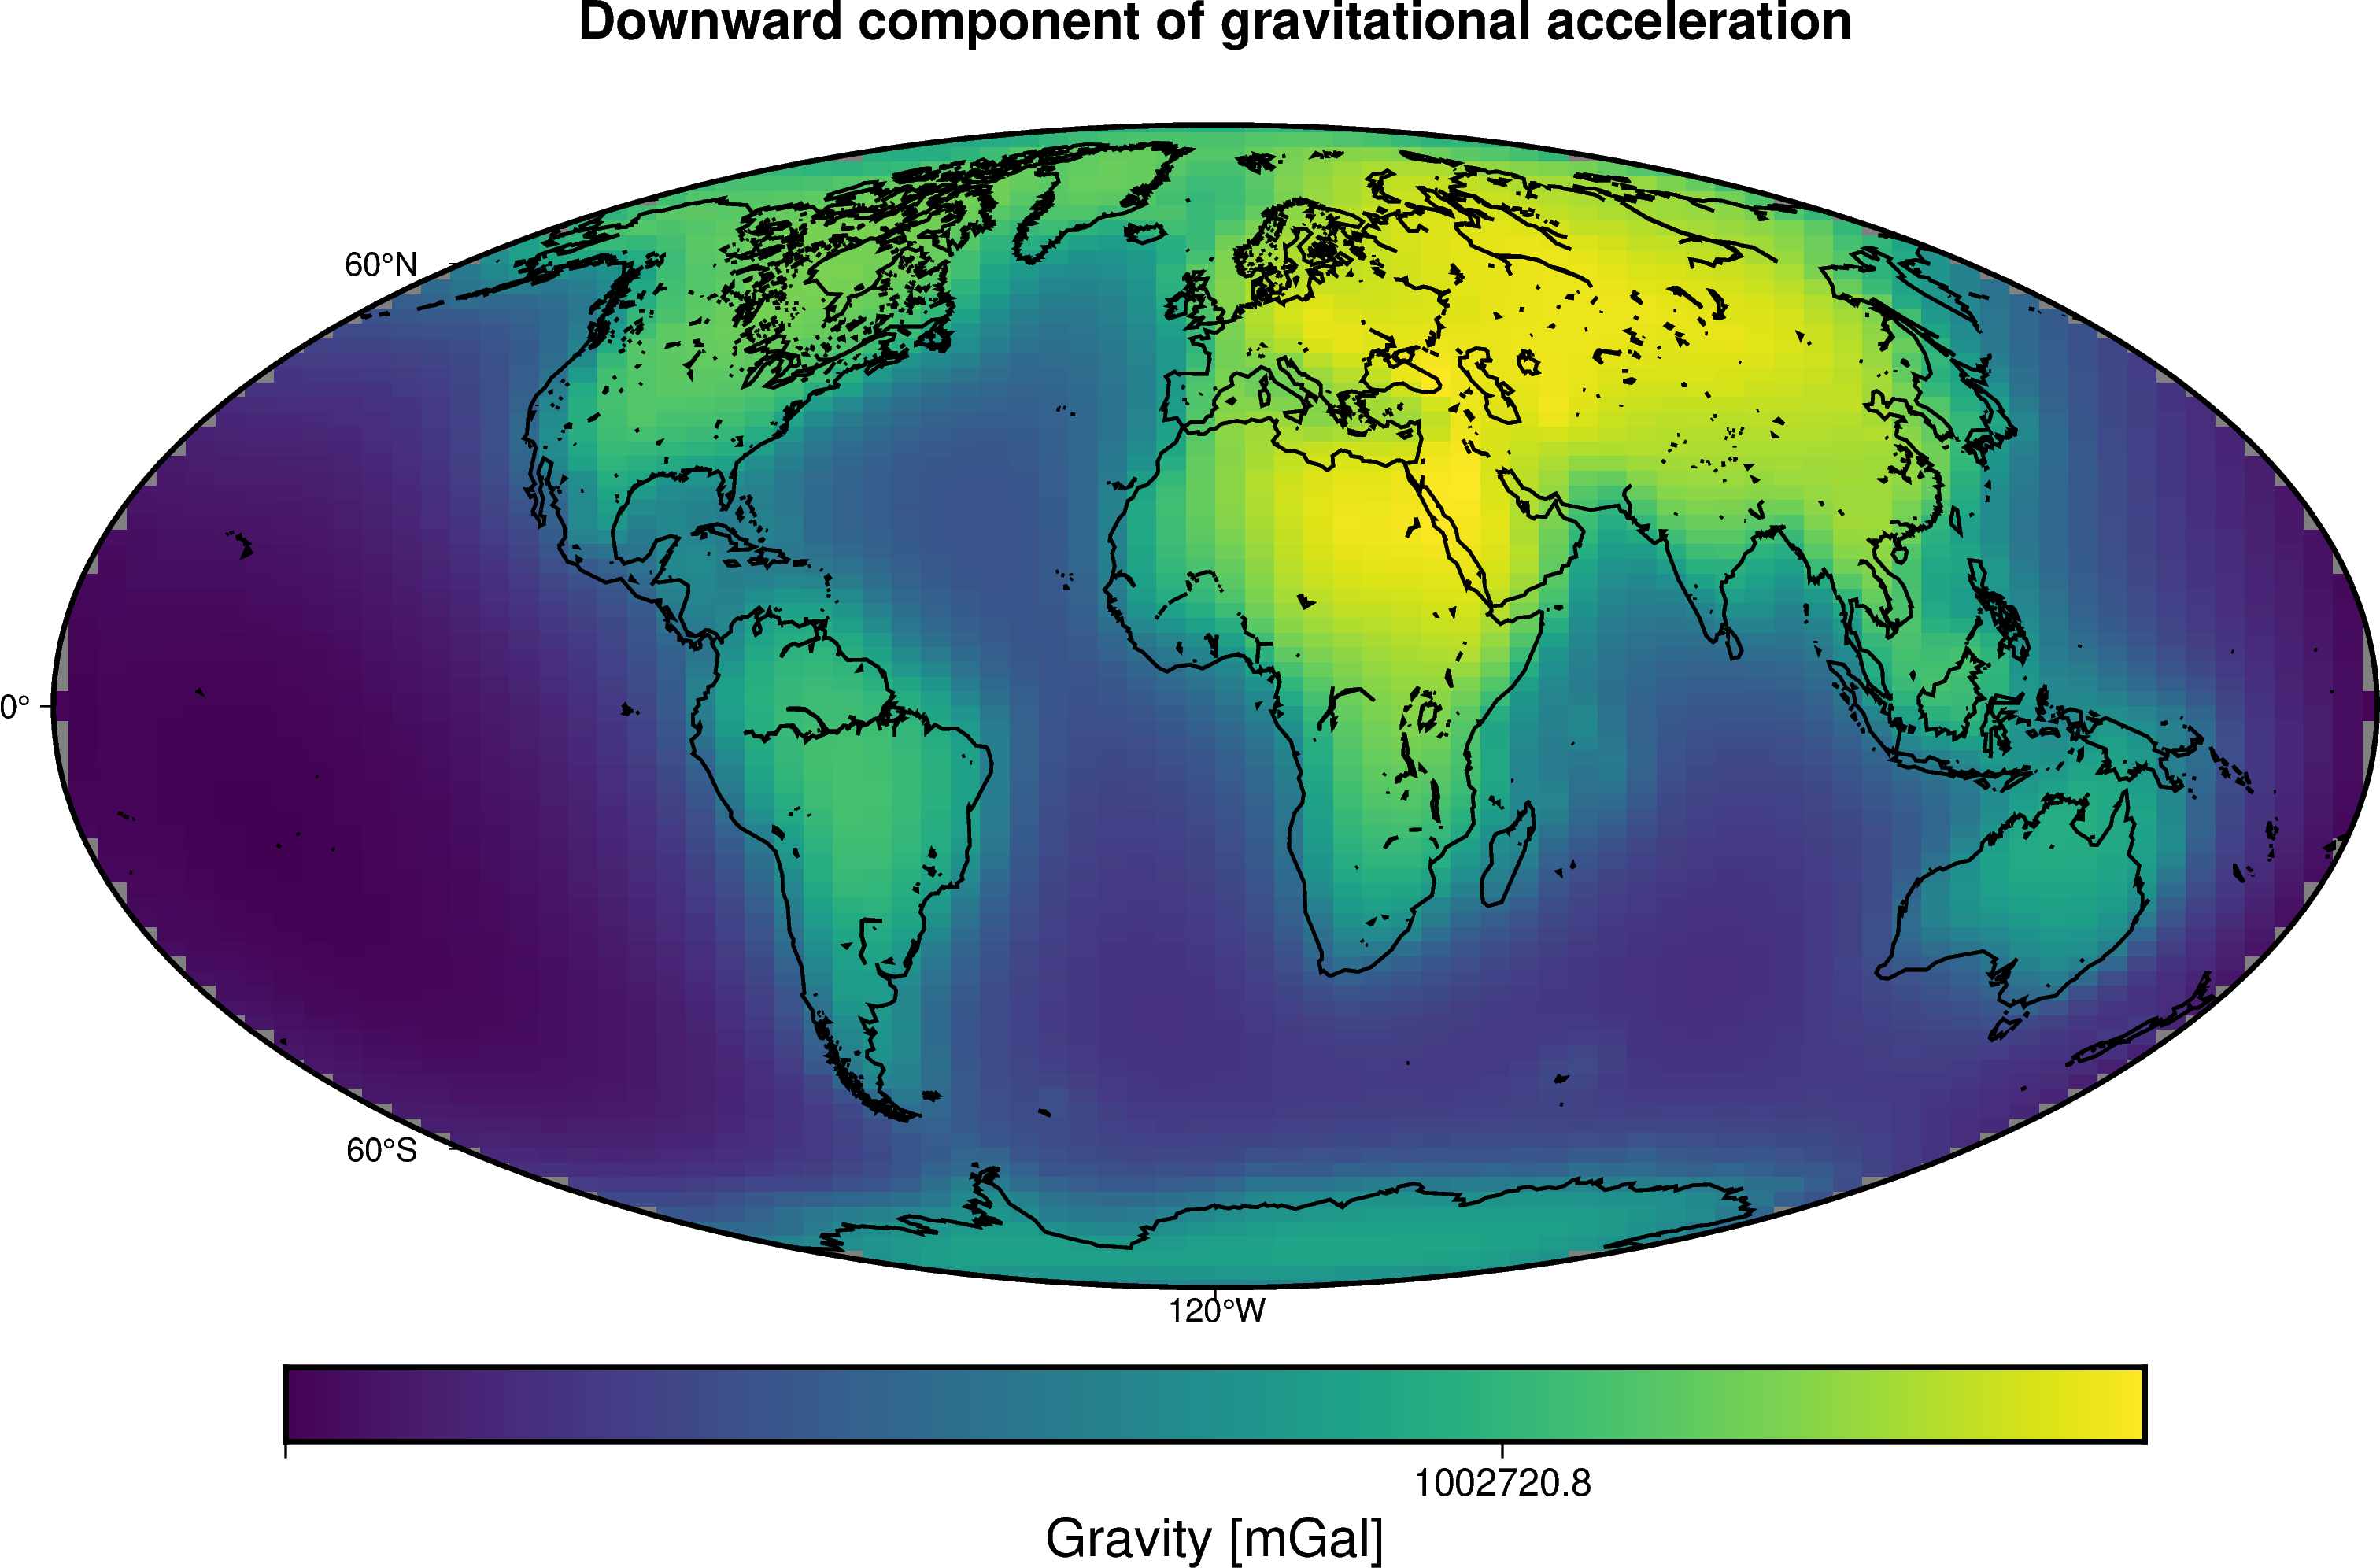

CPU times: total: 7min 39s
Wall time: 53 s


In [7]:
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

tesseroids = []
density = []
tess_den = []
dlong = 5
dlat = 5
longitude_max = 175
longitude_min = -175
latitude_max = 85
latitude_min = -85
depth_min = 0  # centre of the Earth
#depth_max = mean_radius
ddepth = 100e3

for lat in np.arange(latitude_min, latitude_max, dlat):   
    for lon in np.arange(longitude_min, longitude_max, dlong):
        topo = topo_func(lat, lon) * 1e3
        moho = moho_func(lat, lon) * 1e3
        lab = camlab_func(lat, lon) * 1e3
        r_surface = ellipsoid.geocentric_radius(latitude=lat) # in m, for radius corerction 
        depth_max = r_surface
        # Define layer boundaries in radius from Earth's center
        layer_bounds = [r_surface - moho, r_surface - lab, r_surface - 660e3, r_surface - 2890e3, r_surface - 5150e3]
        
        if topo < 0:
            layer_bounds.append(r_surface + topo)
        
        layer_bounds.sort()

        #layer_bounds = [b for b in layer_bounds if b is not None]

        for depth in np.arange(depth_min, depth_max, ddepth):
            r_top_global = r_surface - depth
            r_bottom_raw = r_surface - min(depth + ddepth, depth_max)

            # Check if tesseroid spans across any layer boundary
            split_layers = [b for b in layer_bounds if r_bottom_raw < b < r_top_global] ## b represent layer_bounds, so when b is r_bottom_raw < b < r_top_global is false, then split_layers = []
            split_points = [r_bottom_raw] + split_layers + [r_top_global] ## if split_points = [r_bottom_raw] + [] + [r_top_global], then  split_points = [r_bottom_raw, r_top_global]

            split_points.sort(reverse=True)  # descending from surface to center

            for i in range(len(split_points) - 1):
                r_bottom = split_points[i + 1]
                r_top = split_points[i]
                tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

                radius_mid = 0.5 * (r_top + r_bottom)

                if topo < 0:
                    # Oceanic
                    if r_bottom >= r_surface + topo:
                        rho_top, rho_bottom = 1000.0, 1040.0  # Seawater
                    elif r_bottom >= r_surface - moho:
                        rho_top, rho_bottom = 2850.0, 2950.0  # Oceanic crust
                    elif r_bottom >= r_surface - lab:
                        rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                    elif r_bottom <= 660e3:
                        rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                    elif r_bottom <= 2890e3:
                        rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                    elif r_bottom <= 5150e3:
                        rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                    else:
                        rho_top, rho_bottom = 12000.0, 13000.0  # Inner core
                else:
                    # Continental
                    if r_bottom >= r_surface - moho:
                        rho_top, rho_bottom = 2670.0, 3000.0  # Continental crust
                    elif r_bottom >= r_surface - lab:
                        rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                    elif r_bottom <= 660e3:
                        rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                    elif r_bottom <= 2890e3:
                        rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                    elif r_bottom <= 5150e3:
                        rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                    else:
                        rho_top, rho_bottom = 12000.0, 13000.0  # Inner core

                slope = (rho_top - rho_bottom) / (r_top - r_bottom)
                density_mid = slope * (radius_mid - r_bottom) + rho_bottom
                density.append(density_mid)
                tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])

   
# g'=g−ω2Rcos2λ
# where:
# g' is the effective acceleration due to gravity,
# g is the acceleration due to gravity without rotation,
# Req is the radius of the Earth at equator,
# ω is the angular velocity of the Earth, and
# λ is the latitude.
# gpoles = g−ω2Rcos290 ∘→ gpole=g  ,example
# gequator = g−ω2cos20 ∘= g−ω2R ,example
def gravity_rot(latitudes_deg):
    omega = 7.2921150e-5  # rad/s
    R_eq = 6378137.0      # WGS84 equatorial radius in meters
    phi_rad = np.radians(latitudes_deg)
    g_c = omega**2 * R_eq * np.cos(phi_rad)**2  # centrifugal accel in m/s²
    return g_c * 1e5  # convert to mGal

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=10e3 + ellipsoid.mean_radius,) # calculated uniformly at 10 km above the WGS84 ellipsoid.

# Compute the radial component of the acceleration
#gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
gravity_cal = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")

latitudes_deg = coordinates[1] # Extract latitudes from coordinates
gravity = gravity_cal - gravity_rot(latitudes_deg) # effective gravity

print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")

# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()

In [11]:
np.shape(np.arange(latitude_min, latitude_max,dlat)),np.shape(np.arange(longitude_min, longitude_max,dlong)),np.shape(np.arange(depth_max,depth_min,-ddepth))

((34,), (70,), (64,))

In [12]:
print("Min gravity:", gravity.min())
print("Max gravity:", gravity.max())

Min gravity: 501360.43970163463
Max gravity: 1267565.198253112


In [13]:
np.shape(gravity)

(80, 80)

In [12]:
tesseroids = np.array(tesseroids)
density = np.array(density) 
tess_den = np.array(tess_den) 

In [13]:
np.shape(tesseroids)

(165766, 6)

In [14]:
np.shape(tess_den)

(165766, 7)

In [15]:
tess_den

array([[-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.31291611e+06,  6.35691611e+06,  2.83500000e+03],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.25691611e+06,  6.31291611e+06,  3.30000000e+03],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.24791611e+06,  6.25691611e+06,  3.30000000e+03],
       ...,
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         1.57402414e+05,  2.57402414e+05,  3.92500000e+03],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         5.74024138e+04,  1.57402414e+05,  3.92500000e+03],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         0.00000000e+00,  5.74024138e+04,  3.92500000e+03]])

In [16]:
np.shape(tess_den)

(165766, 7)

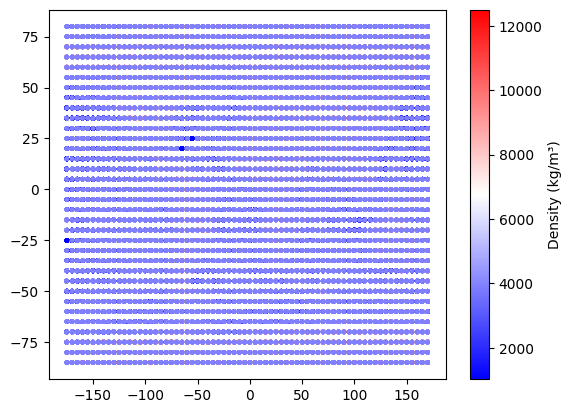

In [17]:
plt.scatter(tess_den[:, 0], tess_den[:, 2], c=tess_den[:, 6], cmap='bwr', s=5)
plt.colorbar(label="Density (kg/m³)")

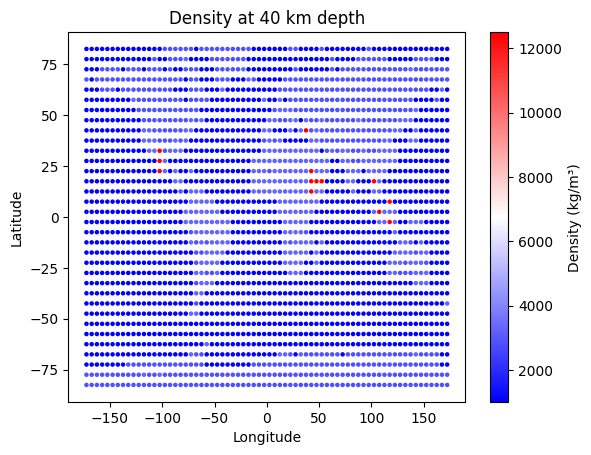

In [32]:
depth_target = 40e3  # 40 km depth
radius_target = mean_radius - depth_target
mask = (tess_den[:, 4] <= radius_target) & (tess_den[:, 5] >= radius_target)
subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='bwr', s=5)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()

In [35]:
# tess_den.([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])
all_depths = mean_radius - tess_den[:, 4:6]
print(f"Depth range: {np.min(all_depths):.1f} m to {np.max(all_depths):.1f} m")

Depth range: -7142.6 m to 6370994.4 m


In [20]:
print("First few r_bottom values:", tess_den[:5, 4])
print("Should be ~6,000,000 (not hundreds of thousands)")

First few r_bottom values: [6312916.11430565 6256916.11430565 6247916.11430565 6156916.11430565
 6056916.11430565]
Should be ~6,000,000 (not hundreds of thousands)


In [21]:
grid

<xarray.Dataset> Size: 104kB
Dimensions:   (northing: 80, easting: 80)
Coordinates:
  * easting   (easting) float64 640B -179.9 -175.3 -170.8 ... 170.8 175.3 179.9
  * northing  (northing) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra     (northing, easting) float64 51kB 6.471e+06 6.471e+06 ... 6.471e+06
Data variables:
    gravity   (northing, easting) float64 51kB 8.277e+05 8.277e+05 ... 9.688e+05

In [22]:
# Rename dimensions and coordinates
grid_rename = grid.rename({
    "northing": "latitude",
    "easting": "longitude"
})

# Extract and rename gravity
observed_gravity = grid_rename["gravity"].rename("observed_gravity")

# Include the height/radius as a coordinate
observed_gravity = observed_gravity.assign_coords(
    height=grid_rename["extra"]
)

# Sort for CF compliance
observed_gravity = observed_gravity.sortby(["latitude", "longitude"])

# Set attributes
observed_gravity.attrs.update({
    "units": "mGal",
    "long_name": "gravity acceleration",
    "description": "observed gravitational acceleration at Earth's surface",
    "crs": "WGS84",
    "Conventions": "CF-1.8",
    "title": "Observed gravity field",
})

# Optional: add attributes to the height coordinate
observed_gravity.coords["height"].attrs.update({
    "units": "m",
    "long_name": "height above reference ellipsoid",
    "standard_name": "height",
    "positive": "up"
})


In [23]:
observed_gravity

<xarray.DataArray 'observed_gravity' (latitude: 80, longitude: 80)> Size: 51kB
array([[827663.14277366, 827657.51078603, 827653.21342199, ...,
        827678.65412777, 827670.4092211 , 827663.42019002],
       [830113.68944238, 830077.57262151, 830111.19994532, ...,
        830411.99817105, 830228.36696108, 830116.92067121],
       [844310.06879929, 844839.70400974, 845785.5659851 , ...,
        844761.44676581, 844295.24366946, 844298.15518125],
       ...,
       [955187.31341539, 953698.12906043, 952581.70154681, ...,
        959311.9316693 , 957127.32622791, 955261.21596961],
       [957960.79560238, 957351.06091789, 956892.06094878, ...,
        959647.74436964, 958751.17754076, 957990.94785617],
       [968791.43802904, 968770.09699175, 968753.07162605, ...,
        968847.87382646, 968818.17097866, 968792.47206112]])
Coordinates:
  * longitude  (longitude) float64 640B -179.9 -175.3 -170.8 ... 175.3 179.9
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra      (latitude, longitude) float64 51kB 6.471e+06 ... 6.471e+06
    height     (latitude, longitude) float64 51kB 6.471e+06 ... 6.471e+06
Attributes:
    units:        mGal
    long_name:    gravity acceleration
    description:  observed gravitational acceleration at Earth's surface
    crs:          WGS84
    Conventions:  CF-1.8
    title:        Observed gravity field

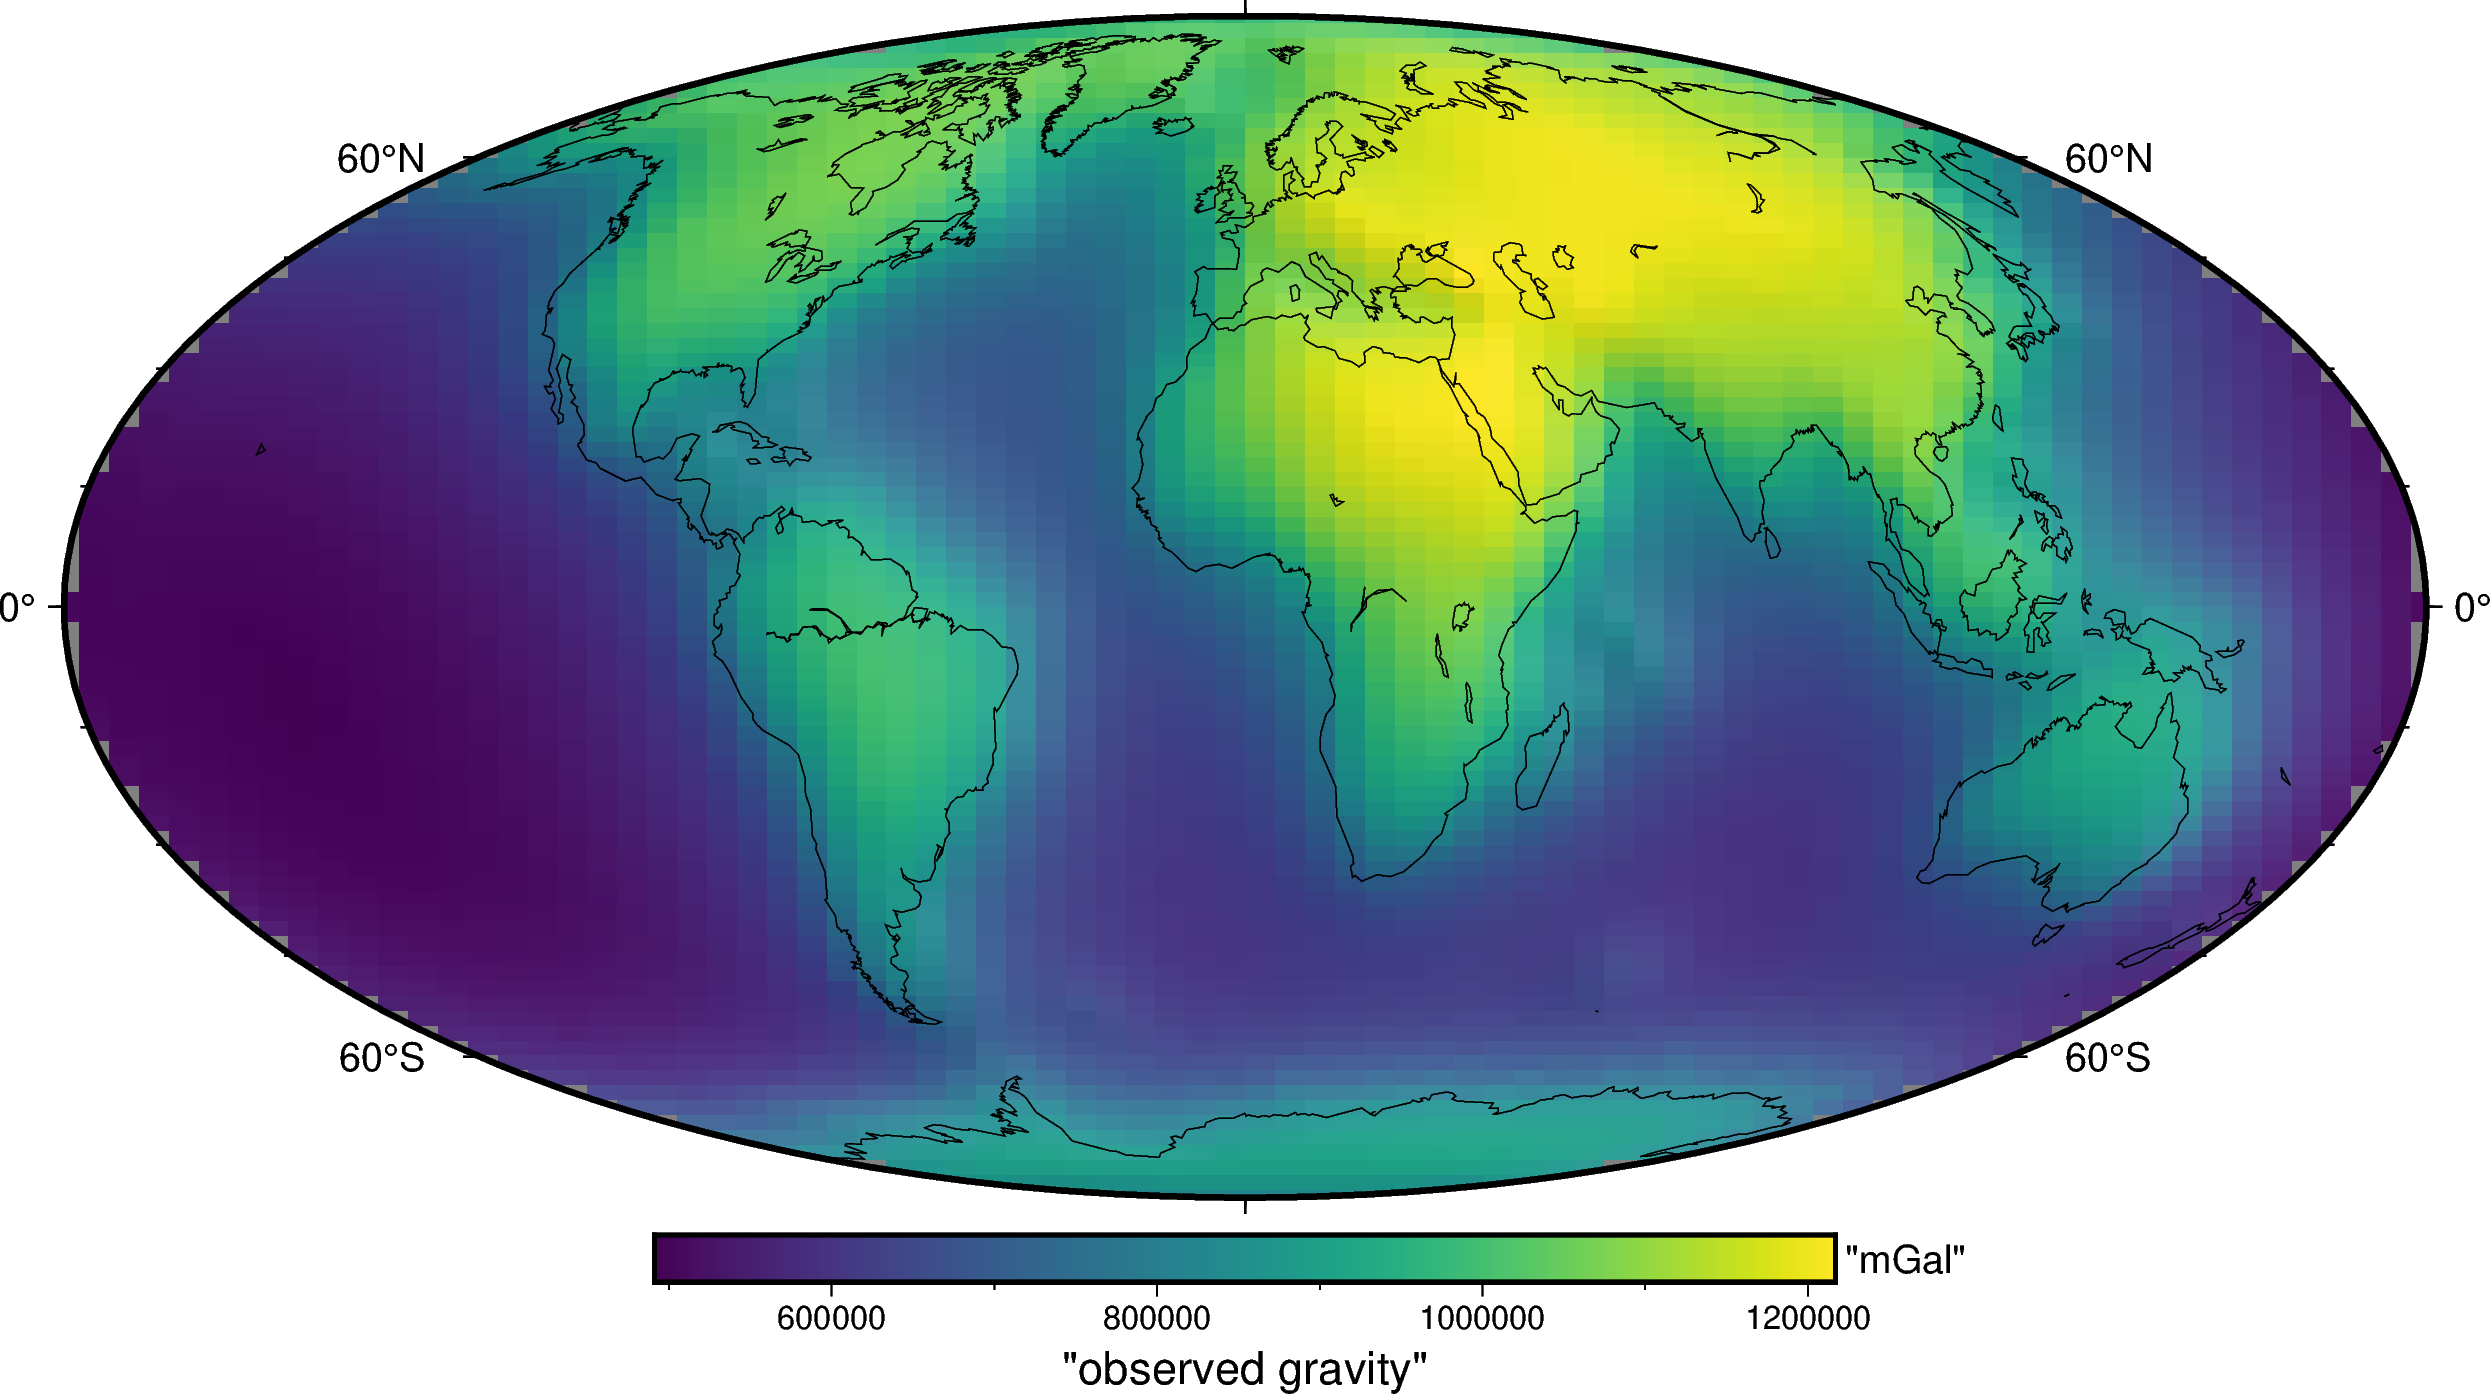

In [24]:
fig = pygmt.Figure()
fig.grdimage(
    observed_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"observed gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [36]:
normal_gravity = ellipsoid.normal_gravity(observed_gravity.latitude, observed_gravity.height)

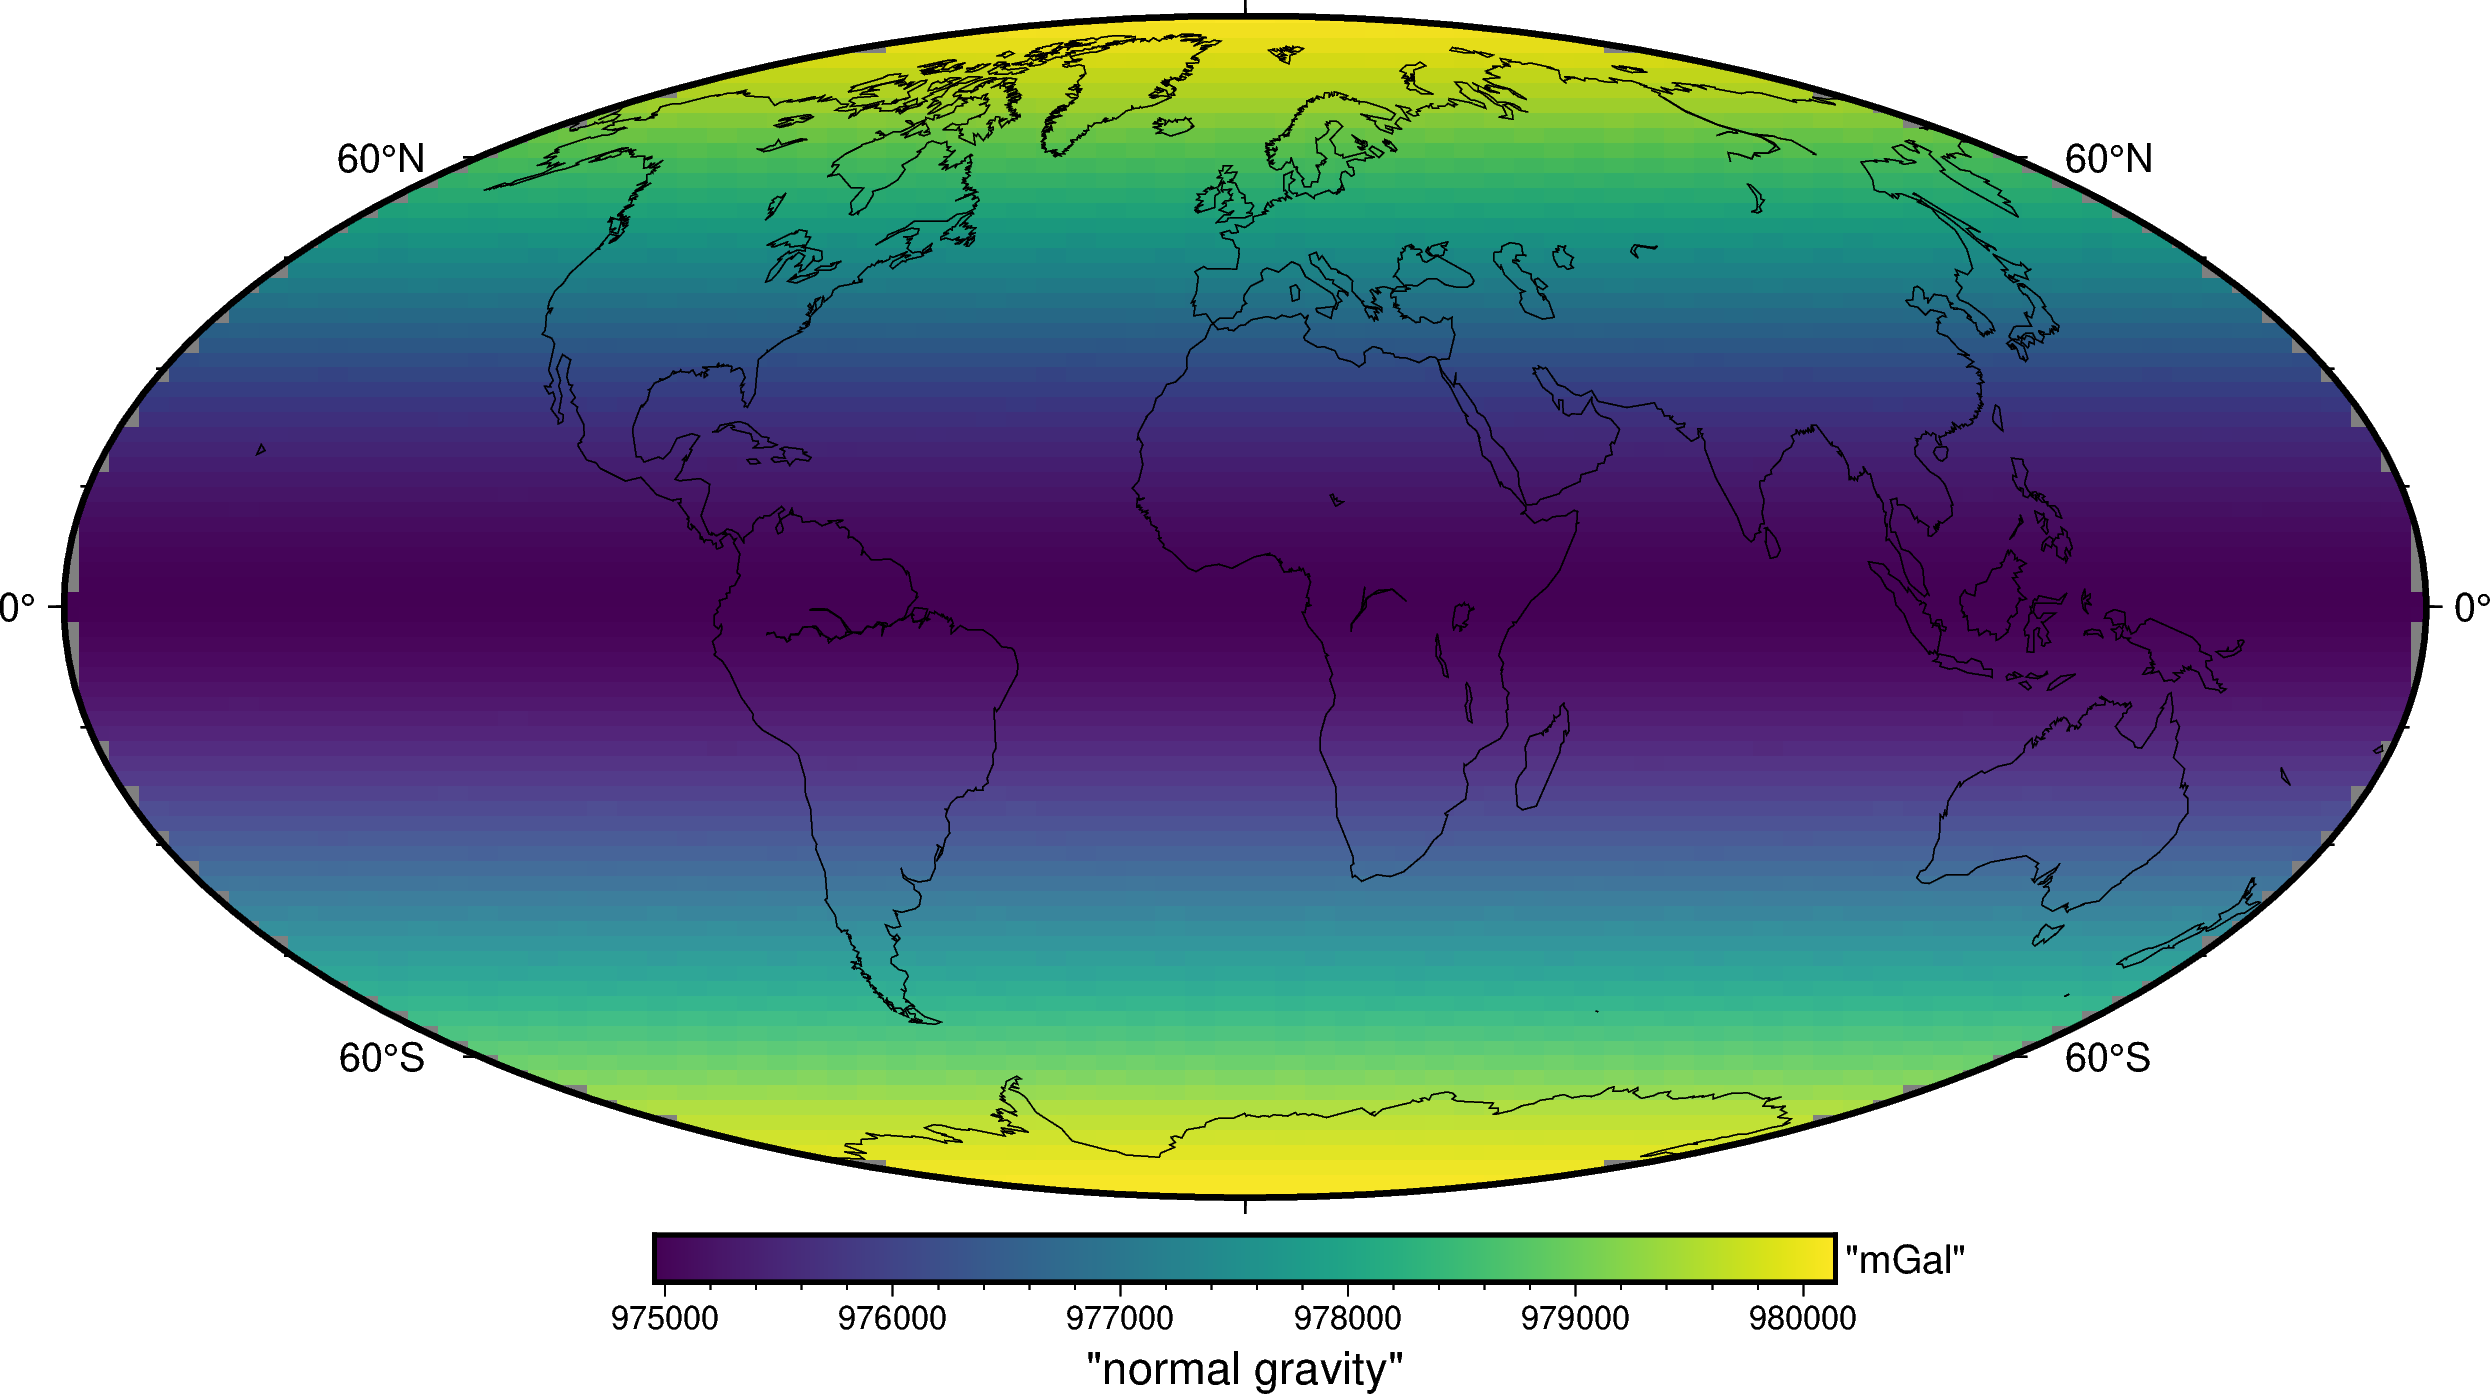

In [37]:
fig = pygmt.Figure()
fig.grdimage(
    normal_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"normal gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [38]:
gravity_disturbance = gravity - normal_gravity
print(gravity_disturbance)


<xarray.DataArray (latitude: 80, longitude: 80)> Size: 51kB
array([[-152479.17909282, -152484.81108045, -152489.10844449, ...,
        -152463.66773871, -152471.91264538, -152478.90167646],
       [-150019.68855046, -150055.80537133, -150022.17804752, ...,
        -149721.37982179, -149905.01103176, -150016.45732163],
       [-135797.97895973, -135268.34374928, -134322.48177392, ...,
        -135346.60099321, -135812.80408956, -135809.89257777],
       ...,
       [ -24920.73434363,  -26409.91869859,  -27526.34621221, ...,
         -20796.11608972,  -22980.72153111,  -24846.83178941],
       [ -22172.5823904 ,  -22782.31707489,  -23241.317044  , ...,
         -20485.63362314,  -21382.20045202,  -22142.43013661],
       [ -11350.88383744,  -11372.22487473,  -11389.25024043, ...,
         -11294.44804002,  -11324.15088782,  -11349.84980536]])
Coordinates:
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
  * longitude  (longitude) float64 640B -179.9 -175.3 

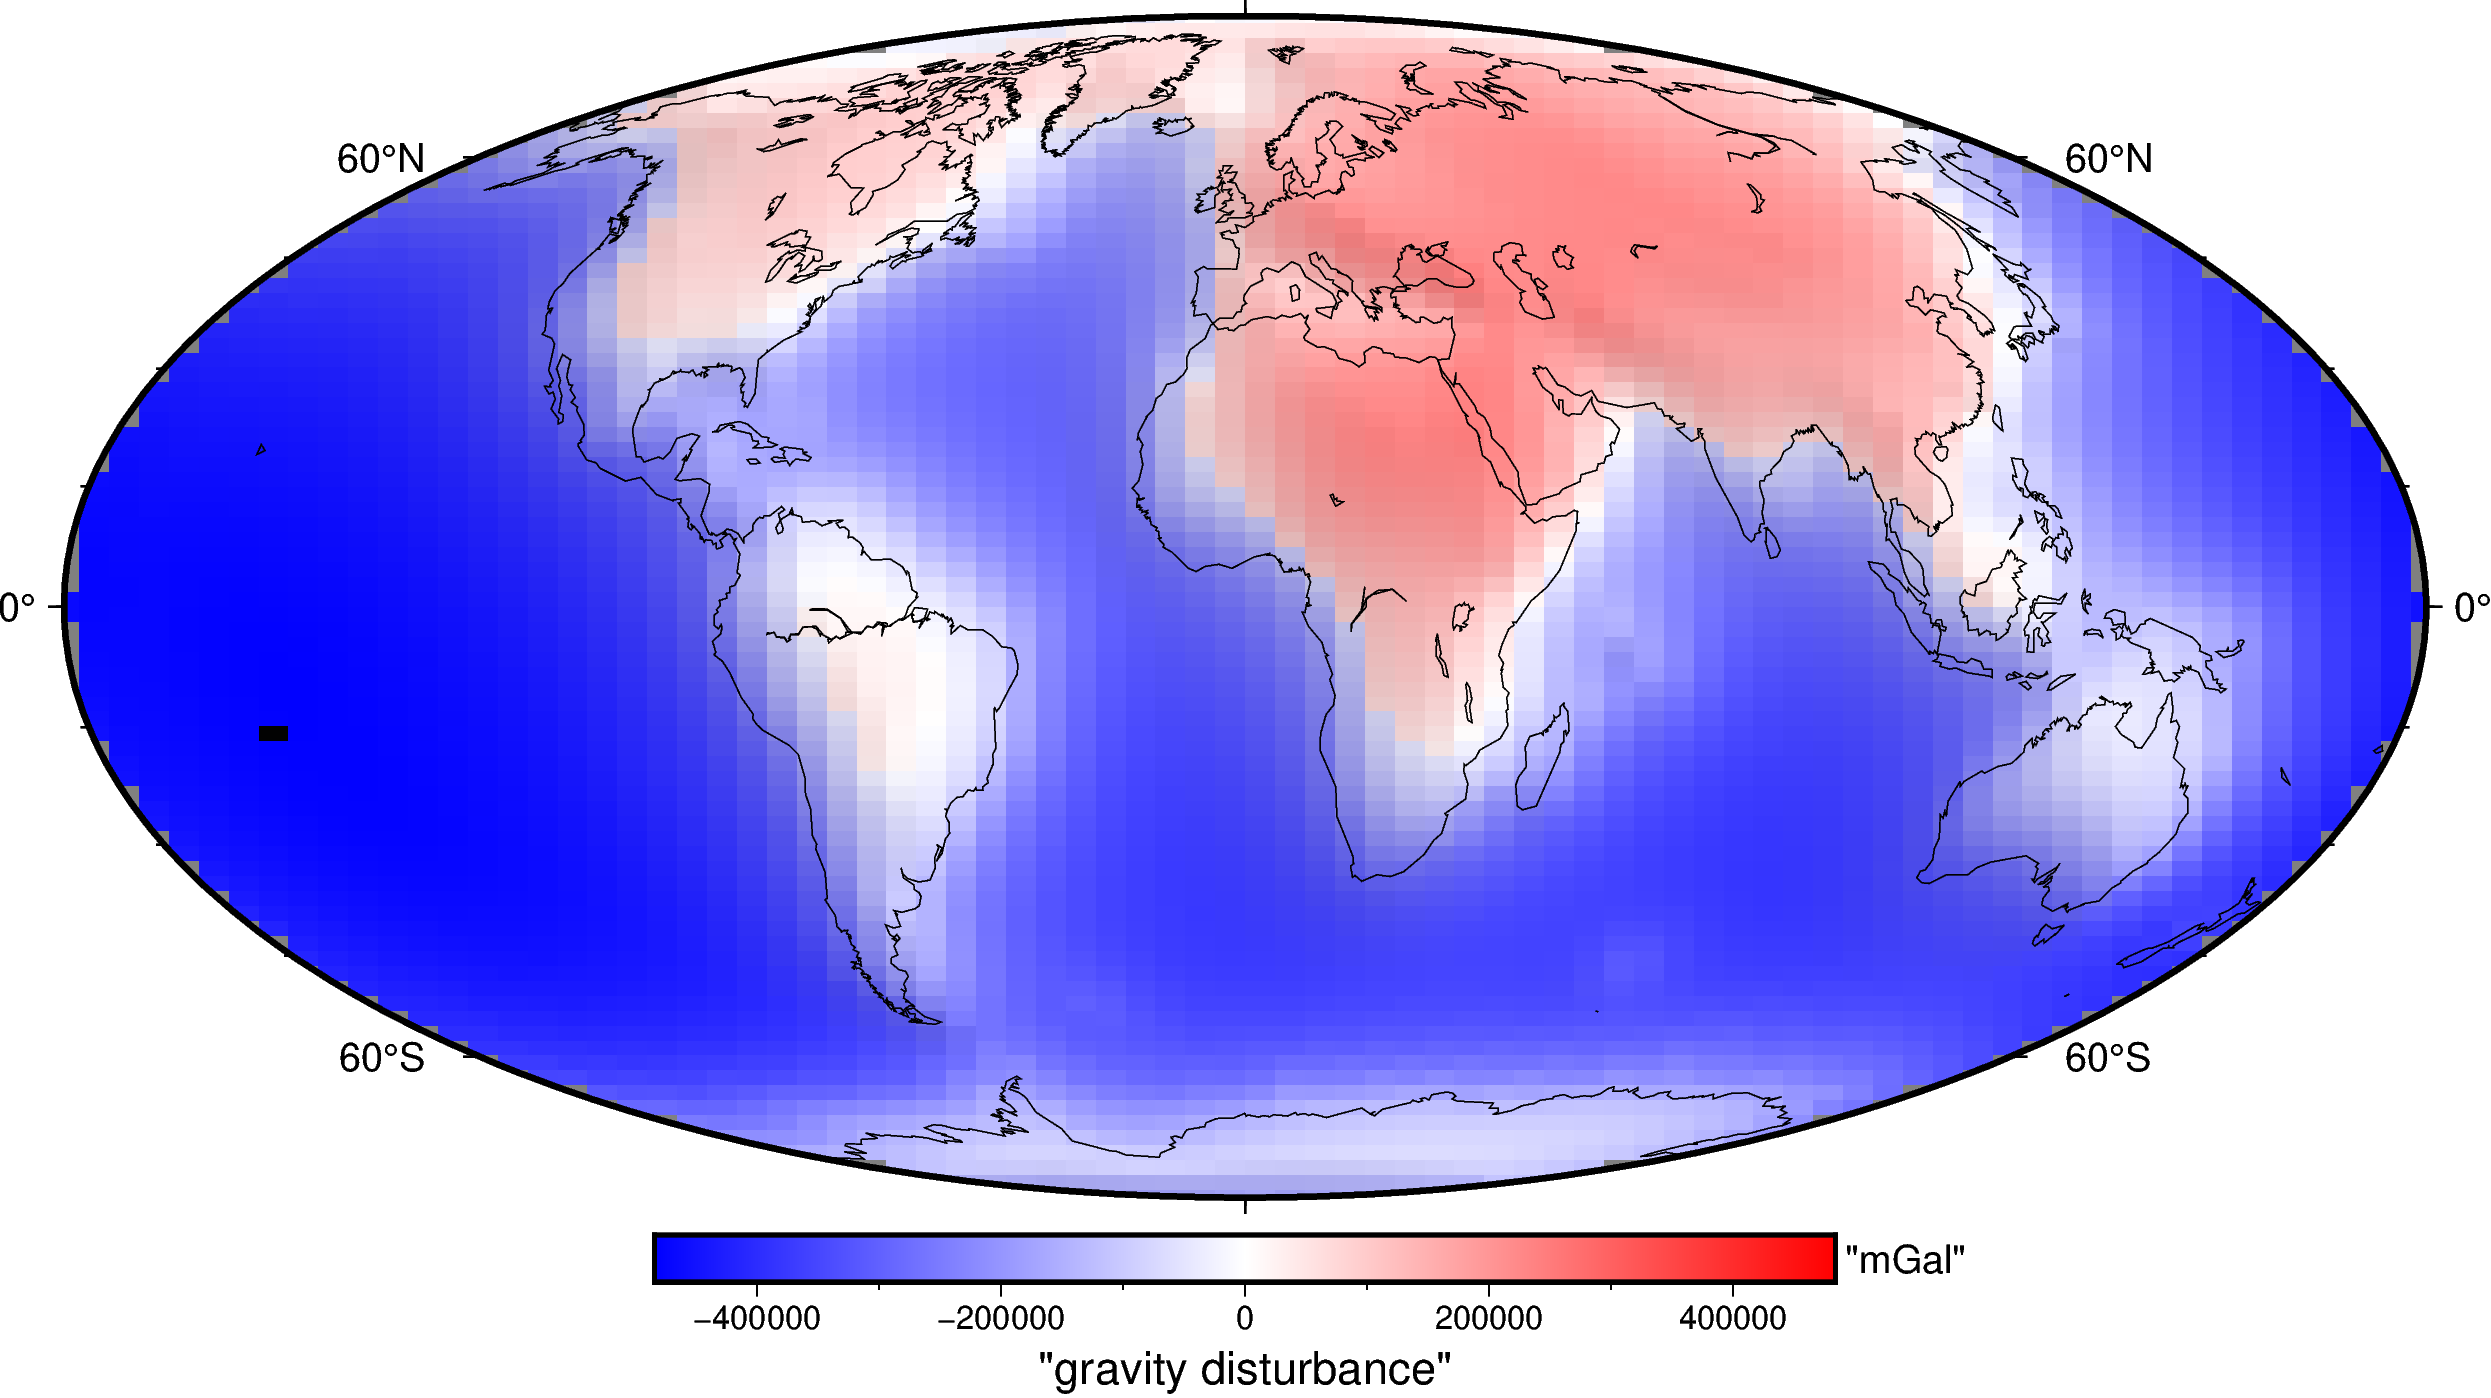

In [39]:
maxabs = vd.maxabs(gravity_disturbance)

fig = pygmt.Figure()
pygmt.makecpt(series=[-maxabs, maxabs], cmap="polar+h")
fig.grdimage(
    gravity_disturbance,
    projection="W20c",
    cmap=True,
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"gravity disturbance"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [29]:
6.471e+06/1e+04

647.1